In [ ]:
!pip install --user kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s MRI

ref                                                         title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
mateuszbuda/lgg-mri-segmentation                            Brain MRI segmentation                              714MB  2019-05-02 21:32:45          33584        634  0.8235294        
jboysen/mri-and-alzheimers                                  MRI and Alzheimers                                   13KB  2017-08-16 17:18:10          20009        423  0.85294116       
sartajbhuvaji/brain-tumor-classification-mri                Brain Tumor Classification (MRI)                     87MB  2020-05-24 16:24:55          19579        360  0.875            
masoudnickparvar/brain-tumor-mri-dataset                    Brain Tumor MRI Data

In [ ]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

brain-tumor-classification-mri.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip brain-tumor-classification-mri.zip

Archive:  brain-tumor-classification-mri.zip
replace Testing/glioma_tumor/image(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Testing/glioma_tumor/image(1).jpg  
replace Testing/glioma_tumor/image(10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

## 1. Data

In [ ]:
train_dataset_path = './Training'
test_dataset_path = './Testing'

In [ ]:
batch_size = 24
epochs = 11

In [ ]:
transform = transforms.Compose(
    [   
        # transforms.ToPILImage(),
        transforms.Resize([128, 128]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [ ]:
# ImageFolder
train_dataset = datasets.ImageFolder(train_dataset_path, transform=transform)
test_dataset = datasets.ImageFolder(test_dataset_path, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_dataset)

2870

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

## 2. Model(ResNet)

In [ ]:
# pretrain resnet
resnet18 = models.resnet18(pretrained=True).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
num_ftrs = resnet18.fc.in_features 
resnet18.fc = nn.Linear(num_ftrs, 4).to(device)

## 3. Loss Function, Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

## 4. Train, Validation

In [ ]:
def train(model, dataLoader, criterion, optimizer):
    model.train()
    cumloss = 0.0
    
    for images, labels in dataLoader:

      images, labels = images.to(device), labels.to(device)

      pred = model(images)
      loss = criterion(pred, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      cumloss += loss.item()

    return cumloss/len(dataLoader)

In [ ]:
def validation(model, dataLoader, lossfunc, epoch):
      model.eval()
      cumloss = 0.0
      correct, data_size = 0, 0
      
      with torch.no_grad():
          for imgs, labels in dataLoader:
    
              imgs, labels = imgs.to(device), labels.to(device)
              
              pred = model(imgs)
              correct += torch.sum(torch.argmax(pred, dim=1) == labels).item()
              data_size += len(imgs)

              loss = lossfunc(pred, labels)
              cumloss += loss.item()

      print(f"validation accuracy - epoch ({epoch}): {correct / data_size}")        
      return cumloss / len(dataLoader)

In [ ]:
losses_train = []
losses_test = []

for i in range(epochs):
    loss_train = train(resnet18, train_loader, criterion, optimizer)
    losses_train.append(loss_train)

    print(f"Epoch: {i} - Loss Train: {loss_train}") 

    loss_val = validation(resnet18, test_loader, criterion, i)
    losses_test.append(loss_val)

    scheduler.step()

Epoch: 0 - Loss Train: 0.11324144969694316
validation accuracy - epoch (0): 0.6979695431472082
Epoch: 1 - Loss Train: 0.1282171758823097
validation accuracy - epoch (1): 0.7284263959390863
Epoch: 2 - Loss Train: 0.076446177981173
validation accuracy - epoch (2): 0.7588832487309645
Epoch: 3 - Loss Train: 0.050750664803975575
validation accuracy - epoch (3): 0.7639593908629442
Epoch: 4 - Loss Train: 0.032778436756537604
validation accuracy - epoch (4): 0.7563451776649747
Epoch: 5 - Loss Train: 0.021145121293375268
validation accuracy - epoch (5): 0.7588832487309645
Epoch: 6 - Loss Train: 0.025724917002177487
validation accuracy - epoch (6): 0.7690355329949239
Epoch: 7 - Loss Train: 0.016096356712902587
validation accuracy - epoch (7): 0.766497461928934
Epoch: 8 - Loss Train: 0.024825920581740015
validation accuracy - epoch (8): 0.8020304568527918
Epoch: 9 - Loss Train: 0.02203205300514431
validation accuracy - epoch (9): 0.799492385786802
Epoch: 10 - Loss Train: 0.014051627135874394
vali

## 5. Visualization

In [ ]:
def plot_loss(losses):
    fig = plt.figure(figsize=(13,5))
    ax = fig.gca()
    
    for loss_name, loss_values in losses.items():
        ax.plot(loss_values, label=loss_name)

    ax.legend(fontsize="16")
    ax.set_xlabel("Epoch", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs epochs", fontsize="16");

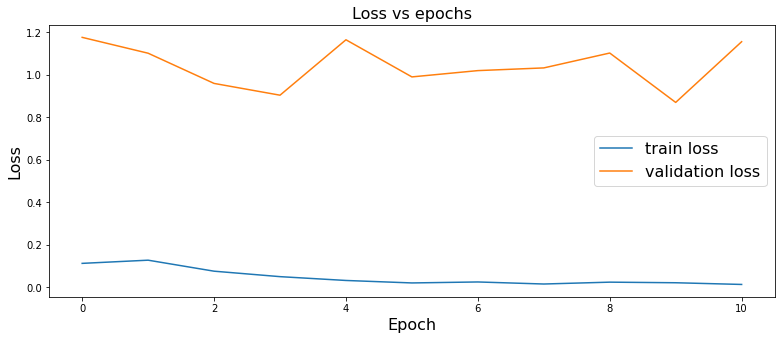

In [ ]:
graph_loss = {'train loss': losses_train,
              'validation loss': losses_test}

plot_loss(graph_loss)